# Part 2: Pneumonia Prediction

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from os import listdir
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms

import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

### Q4 Grad-CAM (5 Pts)

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [3]:
model = CNN()

# Load saved model
model.load_state_dict(torch.load("part2_cnn_weights/CNN_weights.pth", weights_only=True))
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image
    img = cv2.resize(img, (1000, 1000))

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Histogram Equalization
    img = cv2.equalizeHist(img)

    # Gaussian Blur (5x5 kernel)
    final_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return final_img

In [5]:
# Testing label of a single image

input_img = preprocess_image("data_part2/train/PNEUMONIA/person1228_virus_2079.jpeg")
transform = transforms.ToTensor()
input_img = transform(input_img).unsqueeze(0)

# Note that 0 = NORMAL, 1 = PNEUMONIA
output = model(input_img)
predicted = (output > 0.5).float()
print("Predicted:", predicted.item())
print(output)

Predicted: 1.0
tensor([[0.9910]], grad_fn=<SigmoidBackward0>)


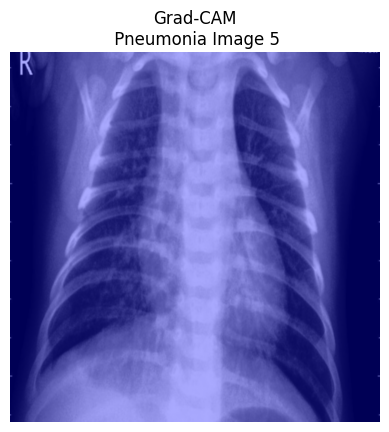

In [6]:
# Images used for displaying integrated gradients:
# Normal images: IM-0117-0001.jpeg, IM-0119-0001.jpeg, IM-0129-0001.jpeg, IM-0147-0001.jpeg, IM-0176-0001.jpeg
# Pneumonia images: person1_bacteria_1.jpeg, person2_bacteria_3.jpeg, person3_bacteria_12.jpeg, person460_virus_948.jpeg, person1228_virus_2079.jpeg

# Was done one by one for each image, see all images side by side in next cell

img_path = "data_part2_processed/train/PNEUMONIA/person1228_virus_2079.jpeg"
original_img = Image.open(img_path)

# Need to resize to 224x224 for Grad-CAM
resized_img = original_img.resize((224, 224))
transform = transforms.ToTensor()
input_tensor = transform(resized_img).unsqueeze(0)

# Implemtation of Grad-CAM using tutorial from https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/CAM%20Metrics%20And%20Tuning%20Tutorial.ipynb
target_layers = [model.conv4]
targets = [ClassifierOutputTarget(0)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Overlay the CAM on the original image
grayscale_cam_upsampled = cv2.resize(grayscale_cam, (1000, 1000))
original_np = np.float32(original_img) / 255.0
original_rgb = np.stack([original_np]*3, axis=-1)
cam_on_original = show_cam_on_image(original_rgb, grayscale_cam_upsampled, use_rgb=True)

plt.imshow(cam_on_original)
plt.title("Grad-CAM\n Pneumonia Image 5")
plt.axis('off')
plt.show()

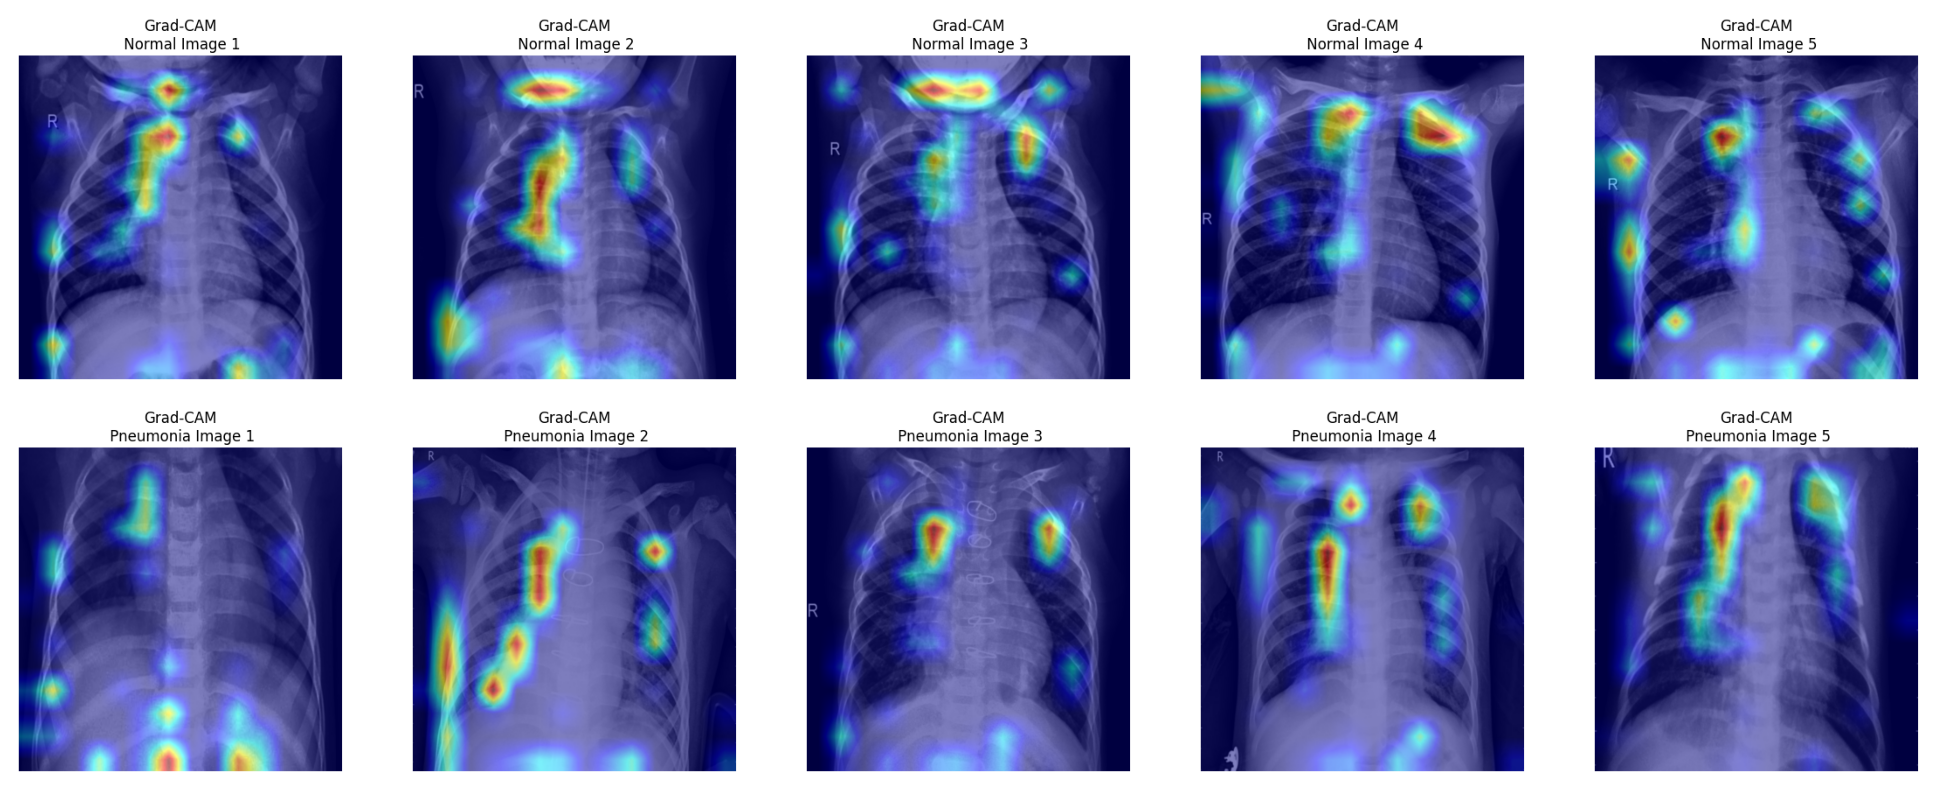

In [7]:
# Plotting Grad-CAM for 5 normal and 5 pneumonia images

image_files = sorted([f for f in os.listdir("grad-cam")])

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, image_file in enumerate(image_files):
    img_path = os.path.join("grad-cam", image_file)
    img = Image.open(img_path)

    axes[idx].imshow(img)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

#### Observations

Q4.2

In the image above we can see that Grad-CAM more or less focuses on the region of where the lungs should be.

Q4.3 & Q4.4

Although the attributions are more or less consitent across samples, they were much more consistent when using the Integrated Gradients method. This was especially the case when using a blurry baseline. Therefore, if we were to propose a method to an actual expert, we would recommend them using the Integrated Gradients method using the blurry baseline.